In [120]:


_PCVERSION_=True


if _PCVERSION_:
    basedir="C:/Users/sipocz/OneDrive/Dokumentumok/GitHub/_EarthQuake/gpos_lin"
else:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    basedir="/content/drive/My Drive/001_AI/_EarthQuake/gpos_lin"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#--------------scikit import 
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#--------------

def outlierStatistic(X_train_predict):
    print(X_train_predict)
    maxX=len(X_train_predict)
    outlier=0
    for i in X_train_predict:
        if i==-1:
            outlier+=1
    print(f"A összes ({maxX} darabból {outlier} darab outlier van. Az {outlier/maxX*100:5.1f} %.)")


def checkvalues(df,columnname,key):
    print(f"{columnname} ellenőrzése !")
    numok=0
    numerr=0
    for i in df.index:
        if df.at[i,columnname] in key:
            #print(df.at[i,columnname])
            numok+=1
            pass
        else:
            numerr+=1
            print(df.at[i,columnname],end=", ")
    sumall=numok+numerr
    print(f"\n{sumall} mintából {numerr} db nem volt megfelelő")


def createcolumn(df,columnname,keys):
    print(f"{columnname} cseréje megy")
    for key in keys:
        df[keys[key]]=0.0
    for key in keys:
        for i in df.index:
            if df.at[i,columnname]==key:
                df.at[i,keys[key]]=1.0


def create_dict(idx,list):
    o={}
    for i in list:
        o[i]=idx+"_"+str(i)
    return o

def create_base_data(df):
    t=['n', 't', 'o']
    columnname="land_surface_condition"
    key=create_dict(columnname,t)


    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    t= ['h', 'w', 'i', 'r', 'u']
    columnname="foundation_type"
    key=create_dict(columnname,t)

    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    t=  ['q', 'n', 'x']
    columnname="roof_type"
    key=create_dict(columnname,t)

    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    t=  ['z', 'v', 'f', 'm', 'x']
    columnname="ground_floor_type"
    key=create_dict(columnname,t)

    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    t=   ['q', 's', 'j', 'x']
    columnname="other_floor_type"
    key=create_dict(columnname,t)

    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    t=   ['j', 's', 't', 'o']
    columnname="position"
    key=create_dict(columnname,t)

    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    t=   ['c', 's', 'f', 'd', 'm', 'a', 'q', 'u', 'n', 'o']
    columnname="plan_configuration"
    key=create_dict(columnname,t)

    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    t=['a', 'w', 'r', 'v']
    columnname="legal_ownership_status"
    key=create_dict(columnname,t)

    #checkvalues(df,columnname,key)
    createcolumn(df,columnname,key)

    # level 1: 0-30, level 2: 0-1427, level 3: 0-12567.
    # level1:0--30
    # level2: 0.0000-----------0.9999
    # level3: 0.000000000------0.000099999
    l1=df.geo_level_1_id
    l2=(df.geo_level_2_id/1427*9999)/10000
    l3=(df.geo_level_2_id/12567*99999)/1000000000
    df["geopos"]=l1+l2+l3
    return(df)



def kill_columns(df):
    notkey=["Unnamed: 0","building_id","legal_ownership_status","geo_level_1_id",	"geo_level_2_id",	"geo_level_3_id", "land_surface_condition",	"foundation_type",	"roof_type",	"ground_floor_type",	"other_floor_type",	"position",	"plan_configuration"]
    for i in df.columns:
        #print(i)
        if i in notkey:
            df.drop(columns=[i], inplace=True)
    return df







In [121]:
def check_similarity_np(np1,np2):
    db=0
    maxi=0
    for ind, i1 in enumerate(np1):
        maxi+=1
        i2=np2[ind]
        if i1!=i2:
            db+=1
    #print(f"{ind}. eset:  {i:3},{i2:3}")
    print(f"hiba:{db} max:{maxi} -- error:{db/maxi*100.0 : 2.6} good %:{100-db/maxi*100.0 : 2.6} %")
    return(1-db/maxi)

In [122]:

features_train=basedir+"/orig/train_values.csv"
labels_train=basedir+"/orig/train_labels.csv"
features_predict=basedir+"/orig/test_values.csv"
X_train=pd.read_csv(features_train)
X_pred=pd.read_csv(features_predict)
y_train=pd.read_csv(labels_train)



In [123]:
X_train.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

In [124]:
added=pd.concat([X_train.geo_level_1_id,X_train.geo_level_2_id,X_train.geo_level_3_id,y_train.damage_grade], axis=1)

In [125]:
#added

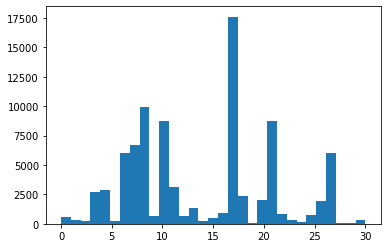

In [126]:
a=plt.hist(added.geo_level_1_id.where(added.damage_grade==3),bins=31)

In [127]:
len(a[0])

31

In [128]:
quake_effect={}
maxi=max(a[0])
for inx,val in enumerate(a[0]):
    quake_effect[inx]=1-(maxi-val)/maxi

In [129]:
eartquakeDist=[]
for idx,i in enumerate(X_train.geo_level_1_id):
    eartquakeDist.append(quake_effect[X_train.geo_level_1_id[idx]])

eartquakeDist2=[]
for idx,i in enumerate(X_pred.geo_level_1_id):
    eartquakeDist2.append(quake_effect[X_pred.geo_level_1_id[idx]])

In [130]:
eartquakeDist2[0]

1.0

In [131]:
added2=pd.concat([X_train.geo_level_1_id,X_train.geo_level_2_id,X_train.geo_level_3_id,y_train.damage_grade,pd.DataFrame(eartquakeDist,columns=["QuakeForce"])], axis=1)

X_train_geolevel=pd.concat([X_train,pd.DataFrame(eartquakeDist,columns=["QuakeForce"])], axis=1)
X_pred_geolevel=pd.concat([X_pred,pd.DataFrame(eartquakeDist2,columns=["QuakeForce"])], axis=1)



In [132]:
X_pred_conv=create_base_data(X_pred_geolevel)
X_train_conv=create_base_data(X_train_geolevel)



land_surface_condition cseréje megy
foundation_type cseréje megy
roof_type cseréje megy
ground_floor_type cseréje megy
other_floor_type cseréje megy
position cseréje megy
plan_configuration cseréje megy
legal_ownership_status cseréje megy
land_surface_condition cseréje megy
foundation_type cseréje megy
roof_type cseréje megy
ground_floor_type cseréje megy
other_floor_type cseréje megy
position cseréje megy
plan_configuration cseréje megy
legal_ownership_status cseréje megy


In [133]:
#--------------------------

In [134]:
#
X_train_ok=kill_columns(X_train_conv)
X_pred_ok=kill_columns(X_pred_conv)
y_train_ok=kill_columns(y_train)



X_train_ok.to_csv(basedir+"/tmp/X_tran_ok.csv",index=False)
X_pred_ok.to_csv(basedir+"/tmp/X_pred_ok.csv",index=False)
y_train_ok.to_csv(basedir+"/tmp/y_train_ok.csv",index=False)




#f=open(basedir+"/tmp/similarity.csv","a")
X_train_ok=pd.read_csv(basedir+"/tmp/X_tran_ok.csv",)
X_pred_ok=pd.read_csv(basedir+"/tmp/X_pred_ok.csv")
y_train_ok=pd.read_csv(basedir+"/tmp/y_train_ok.csv")

X_train_ok.head()
X_pred_ok.head()
#print("Ready")

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,plan_configuration_a,plan_configuration_q,plan_configuration_u,plan_configuration_n,plan_configuration_o,legal_ownership_status_a,legal_ownership_status_w,legal_ownership_status_r,legal_ownership_status_v,geopos
0,3,20,7,6,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.417622
1,2,25,13,5,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.098800
2,2,5,4,5,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.013313
3,1,0,19,3,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.027328
4,3,15,8,7,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.202505


In [135]:
X_pred_ok=kill_columns(X_pred_ok)
X_train_ok=kill_columns(X_train_ok)
y_train_ok=kill_columns(y_train_ok)

t=[1, 2, 3]
columnname="damage_grade"
key=create_dict(columnname,t)


checkvalues(y_train_ok,columnname,key)
createcolumn(y_train_ok,columnname,key)

damage_grade ellenőrzése !

260601 mintából 0 db nem volt megfelelő
damage_grade cseréje megy


In [136]:
y_train_ok

,damage_grade,damage_grade_1,damage_grade_2,damage_grade_3
0,3,0.0,0.0,1.0
1,2,0.0,1.0,0.0
2,3,0.0,0.0,1.0
3,2,0.0,1.0,0.0
4,3,0.0,0.0,1.0
...,...,...,...,...
260596,2,0.0,1.0,0.0
260597,3,0.0,0.0,1.0
260598,3,0.0,0.0,1.0
260599,2,0.0,1.0,0.0


In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


scaler2=MinMaxScaler()
X_train_scale=scaler2.fit_transform(X_train_ok)

#scaler1=StandardScaler()
X_pred_scale=scaler2.fit_transform(X_pred_ok)
"""
scaler3=StandardScaler()
y_train_scale=scaler3.fit_transform(y_train_ok)
"""
y_train_np=y_train_ok.to_numpy()

# szétszedjük a train és test részekre
from sklearn.model_selection import train_test_split
#X_train_train, X_train_test,y_train_train, y_train_test  = train_test_split( X_train_scale, y_train_scale, test_size=0.10, random_state=0)
X_train_train, X_train_test,y_train_train, y_train_test  = train_test_split( X_train_scale, y_train_np, test_size=0.01, random_state=0)




In [138]:
def outlierDropfrom_df(df,inxlist):
    a=df
    out=a.drop(inxlist,axis=0)
    return(out)

In [139]:
def outlierDropfrom_numpyarray(na,inxlist):
    
    out=np.delete (na ,inxlist, axis=0)
    return(out)

In [140]:
def calc_the_range(y_train,hist):    
    num1=sum(1 for val in y_train if val==1)
    #print(num1)
    num2=sum(1 for val in y_train if val==2)
    #print(num2)
    num3=sum(1 for val in y_train if val==3)
    #print(num3)
    
    out=(num1,num1+num2,num1+num2+num3)
    print("out: " ,out)
    steps=[]
    for i in range(len(hist[0])):
        print(hist[0][i], end="")
        if hist[0][i]>out[0]:
            steps.append(i)
            break
    for i in range(len(hist[0])):
        #print(hist[0][i])
        if hist[0][i]>out[1]:
            steps.append(i)
            break
    print("step:",steps)
    limits_out=(hist[1][steps[0]],hist[1][steps[1]])
    print("Limits:",limits_out)
    return (limits_out)

In [141]:
def conv_a_floatlist(alist, range_x):
    o=[]
    print("conv:" ,range_x)
    for i in alist:
        if i<range_x[0]:
            o.append(1)
        if range_x[0]<= i <range_x[1]:
            o.append(2)
        if range_x[1]<=i:
            o.append(3)
    return(o)

In [142]:

# explicitly require this experimental feature
from xgboost import XGBClassifier  
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

#clf = GradientBoostingClassifier(random_state=0,n_estimators=525, max_depth=43, verbose=3, tol=0.0001)
#clf = HistGradientBoostingClassifier(random_state=1, max_depth=53, verbose=3, tol=0.000001, learning_rate=0.6, max_iter=24000,early_stopping=False,min_samples_leaf=5000, scoring="balanced_accuracy")
clf=HistGradientBoostingRegressor(random_state=1, max_depth=113, verbose=3, tol=0.00000001, learning_rate=0.1, max_iter=4000,early_stopping=True,min_samples_leaf=3, loss="poisson",n_iter_no_change=80, warm_start=True)
#clf.fit(X_train_train, y_train_train)

#clf1= MLPClassifier(random_state=1, max_iter=1,verbose=True, tol=1e-10, hidden_layer_sizes=(60,), warm_start=True)
#clf2= MLPClassifier(random_state=1, max_iter=1,verbose=True, tol=1e-10, hidden_layer_sizes=(100,20), warm_start=True)
#clf3= MLPClassifier(random_state=1, max_iter=1,verbose=True, tol=1e-10, hidden_layer_sizes=(100,30), warm_start=True)

'''
clf1=GradientBoostingRegressor(random_state=1, max_depth=113, verbose=1, tol=0.00000001, learning_rate=0.1, n_estimators=20,min_samples_leaf=3, loss="quantile",n_iter_no_change=80, warm_start=True,)
clf2=GradientBoostingRegressor(random_state=1, max_depth=113, verbose=1, tol=0.00000001, learning_rate=0.1, n_estimators=2,min_samples_leaf=3, loss="quantile",n_iter_no_change=80, warm_start=True)
clf3=GradientBoostingRegressor(random_state=1, max_depth=113, verbose=1, tol=0.00000001, learning_rate=0.1, n_estimators=2,min_samples_leaf=3, loss="quantile",n_iter_no_change=80, warm_start=True)
'''
clf1=GradientBoostingRegressor(verbose=3,warm_start=True,n_estimators=5)
clf2=GradientBoostingRegressor(verbose=3,warm_start=True,n_estimators=5)
clf3=GradientBoostingRegressor(verbose=3,warm_start=True,n_estimators=5)


# clf1= GradientBoostingClassifier(verbose=3, tol=1e-10, warm_start=True,n_estimators=10)
# clf2= GradientBoostingClassifier(verbose=3, tol=1e-10, warm_start=True,n_estimators=10)
# clf3= GradientBoostingClassifier(verbose=3, tol=1e-10, warm_start=True,n_estimators=10)



In [143]:

yhiba=[]
for inx,i in enumerate(y_train_train):
    yhiba.append(0)
yhiba[0]=1


In [144]:
n=20
i=0
yt0=y_train_train[:,0]
yt1=y_train_train[:,1]
yt2=y_train_train[:,2]
yt3=y_train_train[:,3]
clf1.fit(X_train_train,yt1)
clf2.fit(X_train_train,yt2)
clf3.fit(X_train_train,yt3)


      Iter       Train Loss   Remaining Time 
         1           0.0833            3.47s
         2           0.0802            2.57s
         3           0.0776            1.69s
         4           0.0755            0.84s
         5           0.0736            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.2407            3.42s
         2           0.2370            2.55s
         3           0.2339            1.69s
         4           0.2314            0.84s
         5           0.2291            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.2137            3.32s
         2           0.2064            2.49s
         3           0.2005            1.66s
         4           0.1956            0.83s
         5           0.1915            0.00s


GradientBoostingRegressor(n_estimators=5, verbose=3, warm_start=True)

In [145]:
from sklearn.neural_network import MLPClassifier
clfhiba3=MLPClassifier(random_state=1, max_iter=10, warm_start=True, verbose=True,hidden_layer_sizes=(60,500,5))
clfhiba3.fit(X_train_train,yhiba)

Iteration 1, loss = 0.00295379
Iteration 2, loss = 0.00010094
Iteration 3, loss = 0.00007857
Iteration 4, loss = 0.00007376
Iteration 5, loss = 0.00006352
Iteration 6, loss = 0.00005093
Iteration 7, loss = 0.00004983
Iteration 8, loss = 0.00004696
Iteration 9, loss = 0.00004742
Iteration 10, loss = 0.00004567


MLPClassifier(hidden_layer_sizes=(60, 500, 5), max_iter=10, random_state=1,
              verbose=True, warm_start=True)

In [146]:
# ITT kezdődik az okítási ciklus IDe jön vissza

In [162]:
def reconvert (X):
    yo=[]
    y1=clf1.predict(X)
    y2=clf2.predict(X)
    y3=clf3.predict(X)
    yerror=clfhiba3.predict(X)
    o=1
    
    for idx,_ in enumerate(X):
       if y1[idx]==max(y1[idx],y2[idx],y3[idx]):
           o=1
       if y2[idx]==max(y1[idx],y2[idx],y3[idx]):
           o=2
       if y3[idx]==max(y1[idx],y2[idx],y3[idx]):
           o=3
       '''
       ox=o
       if ox==3 and yerror[idx]:
           o=2
       if ox==1 and yerror[idx]:
           o=2
       if ox==2 and yerror[idx]:
           # 2 eset van 
           if y3[idx]>y1[idx]:
               o=3
           else:
               o=1

       '''
       
       yo.append(o)
    return(yo)
    

In [193]:


n=len(clf1.train_score_)
nextsave=n+500
while 1==1:
    
    n=n+1    
    nhiba=len(clf1.train_score_)
    print(f"n_hiba:{nhiba}")
    nhiba=nhiba+10    
    
    clf1.set_params(alpha=0.99,n_estimators=nhiba,warm_start=True,verbose=0)
    clf2.set_params(alpha=0.99,n_estimators=nhiba,warm_start=True,verbose=0)
    clf3.set_params(alpha=0.99,n_estimators=nhiba,warm_start=True,verbose=0)
   
    clf1.fit(X_train_train,yt1)
    clf2.fit(X_train_train,yt2)
    clf3.fit(X_train_train,yt3)
   
  
    o1=clf1.train_score_[-1]
    o2=clf2.train_score_[-1]
    o3=clf3.train_score_[-1]
    #
    # Save the model regularly!
    #
    if nhiba>nextsave:
        nextsave=nhiba+500
        import pickle
        nhibastr=str(nhiba)
        fname1=basedir+"/clf1_"+nhibastr+"_data.pickled"
        with open(fname1, 'wb') as file:
            pickle.dump(clf1, file)

        fname2=basedir+"/clf2_"+nhibastr+"_data.pickled"
        with open(fname2, 'wb') as file:
            pickle.dump(clf2, file)

        fname3=basedir+"/clf3_"+nhibastr+"_data.pickled"
        with open(fname3, 'wb') as file:
            pickle.dump(clf3, file)


    if nhiba>12070:
        break    
        
    print(f"damage grade in {nhiba:8} nextsave={nextsave}. step: {o1:8.6f},{o2:8.6f},{o3:8.6f}" )
 

n_hiba:5505
damage grade in     5515 nextsave=6005. step: 0.046946,0.170270,0.132384
n_hiba:5515
damage grade in     5525 nextsave=6005. step: 0.046943,0.170253,0.132375
n_hiba:5525
damage grade in     5535 nextsave=6005. step: 0.046935,0.170238,0.132365
n_hiba:5535
damage grade in     5545 nextsave=6005. step: 0.046929,0.170219,0.132353
n_hiba:5545
damage grade in     5555 nextsave=6005. step: 0.046921,0.170206,0.132343
n_hiba:5555
damage grade in     5565 nextsave=6005. step: 0.046913,0.170194,0.132334
n_hiba:5565
damage grade in     5575 nextsave=6005. step: 0.046906,0.170181,0.132324
n_hiba:5575
damage grade in     5585 nextsave=6005. step: 0.046898,0.170167,0.132314
n_hiba:5585
damage grade in     5595 nextsave=6005. step: 0.046888,0.170152,0.132306
n_hiba:5595
damage grade in     5605 nextsave=6005. step: 0.046882,0.170134,0.132299
n_hiba:5605
damage grade in     5615 nextsave=6005. step: 0.046878,0.170121,0.132291
n_hiba:5615
damage grade in     5625 nextsave=6005. step: 0.04687

In [186]:

import pickle
fname1=basedir+"/clf1_3500_data.pickle"
with open(fname1, 'wb') as file:
    pickle.dump(clf1, file)

fname2=basedir+"/clf2_3500_data.pickle"
with open(fname2, 'wb') as file:
    pickle.dump(clf2, file)

fname3=basedir+"/clf3_3500_data.pickle"
with open(fname3, 'wb') as file:
    pickle.dump(clf3, file)





In [149]:

yhibaold=[]
maxlen=len(y_train_train)
#maxlen=1000
stimm=0
for idx,_ in enumerate(y1):
    if idx in range(0,maxlen):
        ou1=y1[idx]
        ou2=y2[idx]
        ou3=y3[idx]
        ouh=yhiba_pred[idx]
        match=(y_train_train[idx][0]==1 and ou1==max(ou1,ou2,ou3)) or (y_train_train[idx][0]==2 and ou2==max(ou1,ou2,ou3)) or (y_train_train[idx][0]==3 and ou3==max(ou1,ou2,ou3)) 
        if match:
            yhibaold.append(0)
            stimm+=1
        else:
            yhibaold.append(1)
        if idx%10000==1:
            print(f"{y_train_train[idx]} :{ou1:6.3f} _ {ou2:6.3f} _ {ou3:6.3f} _ {match}_{ouh:6.3f}")

print(maxlen,stimm,stimm/maxlen) 
#print(yhiba)



[2. 0. 1. 0.] : 0.009 _  0.225 _  0.620 _ False_ 0.000
[1. 1. 0. 0.] : 0.593 _  0.363 _  0.126 _ True_ 0.000
[2. 0. 1. 0.] : 0.476 _  0.494 _  0.048 _ True_ 0.000
[2. 0. 1. 0.] :-0.003 _  0.432 _  0.602 _ False_ 0.000
[2. 0. 1. 0.] : 0.177 _  0.727 _  0.109 _ True_ 0.000
[3. 0. 0. 1.] :-0.007 _  0.429 _  0.575 _ True_ 0.000
[2. 0. 1. 0.] : 0.140 _  0.759 _  0.128 _ True_ 0.000
[2. 0. 1. 0.] : 0.154 _  0.659 _  0.166 _ True_ 0.000
[3. 0. 0. 1.] :-0.005 _  0.120 _  0.877 _ True_ 0.000
[1. 1. 0. 0.] : 0.147 _  0.615 _  0.228 _ False_ 0.000
[2. 0. 1. 0.] :-0.010 _  0.148 _  0.862 _ False_ 0.000
[1. 1. 0. 0.] : 0.670 _  0.397 _ -0.040 _ True_ 0.000
[2. 0. 1. 0.] : 0.004 _  0.193 _  0.829 _ False_ 0.000
[3. 0. 0. 1.] : 0.002 _  0.458 _  0.531 _ True_ 0.000
[3. 0. 0. 1.] :-0.009 _  0.104 _  0.893 _ True_ 0.000
[3. 0. 0. 1.] : 0.004 _  0.452 _  0.556 _ True_ 0.000
[1. 1. 0. 0.] : 0.320 _  0.561 _  0.132 _ False_ 0.000
[2. 0. 1. 0.] : 0.013 _  0.816 _  0.161 _ True_ 0.000
[3. 0. 0. 1.] :-0.009 

In [150]:
yhiba=yhibaold

In [151]:
i=0

n=n+10

while 1==1:
   
    nhiba=clfhiba3.n_iter_
    nhiba=nhiba+10    
    

    clfhiba3.set_params(warm_start=True,verbose=3,learning_rate="adaptive",max_iter=nhiba)
 
    clfhiba3.fit(X_train_train,yhiba)
  

    ohiba=clfhiba3.score(X_train_train,yhiba)
    if nhiba>550:
        break    
    print(f"damage grade in {nhiba:8}. step: {ohiba:8.6f}" )

rade in      429. step: 0.707381
Iteration 421, loss = 0.56447394
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
damage grade in      430. step: 0.707040
Iteration 422, loss = 0.56448940
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
damage grade in      431. step: 0.707214
Iteration 423, loss = 0.56449091
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
damage grade in      432. step: 0.707075
Iteration 424, loss = 0.56446701
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
damage grade in      433. step: 0.707137
Iteration 425, loss = 0.56446139
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
damage grade in      434. step: 0.707361
Iteration 426, loss = 0.56441907
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
damage grade in      435

In [176]:
y1=clf1.predict(X_train_train)
y2=clf2.predict(X_train_train)
y3=clf3.predict(X_train_train)
yhiba_pred=clfhiba3.predict(X_train_train)

In [177]:
clf3.train_score_[-1]

0.13535196806372593

In [154]:
def show_similarity(a,b):
    for i in range(min(len(a),1000)):
        print(f"{a[i]}-{b[i]} ",end="")

In [155]:
def search_outliers(y_t1,y_pred,X_orig,yrealpred):
    y1=[] # y orig 
    x1=[] # X orig
    yp=[] # y predikt
    yrp=[] # y predicted real value
    for inx,i in enumerate(y_t1):
        if y_t1[inx][0]==y_pred[inx]:
            pass
        else:
            y1.append(y_t1[inx][0])
            x1.append(X_orig[inx])
            yp.append(y_pred[inx])
            yrp.append(yrealpred[inx])
    out=(y1,yp,x1,yrp)
    return out






In [156]:
# futtass ez felett !!

In [157]:
X_train_train

array([[0.25      , 0.02512563, 0.1010101 , ..., 0.        , 1.        ,
        0.22846051],
       [0.125     , 0.00502513, 0.05050505, ..., 0.        , 1.        ,
        0.59586796],
       [0.125     , 0.        , 0.1010101 , ..., 0.        , 1.        ,
        0.87090745],
       ...,
       [0.        , 0.        , 0.04040404, ..., 0.        , 1.        ,
        0.47198577],
       [0.25      , 0.02512563, 0.1010101 , ..., 0.        , 1.        ,
        0.70982493],
       [0.125     , 0.0201005 , 0.07070707, ..., 0.        , 1.        ,
        0.67640778]])

In [194]:
ypred1=reconvert(X_train_train)
check_similarity_np(ypred1,y_train_train[:,0])

hiba:64795 max:257994 -- error: 25.1149 good %: 74.8851 %


0.7488507484670186

In [195]:
ypred2=reconvert(X_train_test)
check_similarity_np(ypred2,y_train_test[:,0])

hiba:700 max:2607 -- error: 26.8508 good %: 73.1492 %


0.7314921365554277

In [180]:
#outfile generation
y_pred_ok=reconvert(X_pred_scale)
print("Prediction End")

X_pred_bd=pd.read_csv(basedir+"/orig/test_values.csv")

#y_pred_ok_int=conv_a_floatlist(y_pred_ok,range_x)

Prediction End


In [181]:
buildingid=X_pred_bd["building_id"]

head2=y_pred_ok


outdf=pd.DataFrame(data={"damage_grade":y_pred_ok} ,index=buildingid)
outdf.index.name="building_id"


outdf.head()
st=40
sts=str(st)
outdf.to_csv(basedir+"/out/submission_"+sts+"_xgboost.csv")
print()
print(basedir+"/out/submission_"+sts+"_xgboost.csv")


C:/Users/sipocz/OneDrive/Dokumentumok/GitHub/_EarthQuake/gpos_lin/out/submission_40_xgboost.csv


In [ ]:
if not( _PCVERSION_):
    !head "/content/drive/My Drive/001_AI/_EarthQuake/gpos_lin/out/submission_24_xgboost.csv"

In [167]:
X_pred_scale

array([[0.28571429, 0.0201005 , 0.06593407, ..., 0.        , 1.        ,
        0.56170323],
       [0.14285714, 0.02512563, 0.13186813, ..., 0.        , 1.        ,
        0.19576828],
       [0.14285714, 0.00502513, 0.03296703, ..., 0.        , 1.        ,
        0.71028087],
       ...,
       [0.        , 0.05025126, 0.02197802, ..., 0.        , 1.        ,
        0.73558512],
       [0.14285714, 0.00502513, 0.08791209, ..., 0.        , 0.        ,
        0.21615666],
       [0.14285714, 0.01005025, 0.10989011, ..., 0.        , 1.        ,
        0.83998508]])

<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM.png" title="Python Logo"/>